In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from matplotlib.patches import ConnectionPatch
import seaborn as sns

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

%matplotlib inline

# Rotating single vector

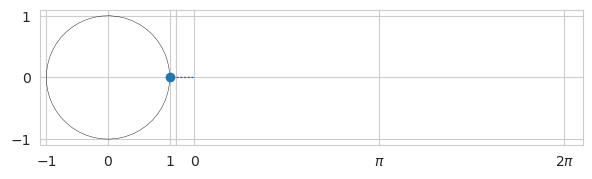

In [13]:
with sns.axes_style('whitegrid'):
    fig, (axl, axr) = plt.subplots(
        ncols=2,
        sharey=True,
        figsize=(7, 3),
        gridspec_kw=dict(width_ratios=[1, 3], wspace=0),
    )
    axl.set_aspect(1)
    axr.set_box_aspect(1 / 3)
    axr.xaxis.set_ticks([0, np.pi, 2 * np.pi], ["0", r"$\pi$", r"$2\pi$"])

# draw circle with initial point in left Axes
x = np.linspace(0, 2 * np.pi, 50)
axl.plot(np.cos(x), np.sin(x), "black", lw=0.3)
point, = axl.plot(0, 0, "o")

# draw full curve to set view limits in right Axes
sine, = axr.plot(x, np.sin(x))

# draw connecting line between both graphs
con = ConnectionPatch(
    (1, 0),
    (0, 0),
    "data",
    "data",
    axesA=axl,
    axesB=axr,
    color="C0",
    ls="dotted",
)
fig.add_artist(con)


def animate(i):
    x = np.linspace(0, i, int(i * 25 / np.pi))
    sine.set_data(x, np.sin(x))
    x, y = np.cos(i), np.sin(i)
    point.set_data([x], [y])
    con.xy1 = x, y
    con.xy2 = i, y
    return point, sine, con


ani = FuncAnimation(
    fig,
    animate,
    interval=50,
    blit=False,  # blitting can't be used with Figure artists
    frames=x,
    repeat_delay=100,
)

In [3]:
ani

In [4]:
ani.save('../../assets/images/optimization/rotation_and_sinusoid.gif');

# Step-function approximation

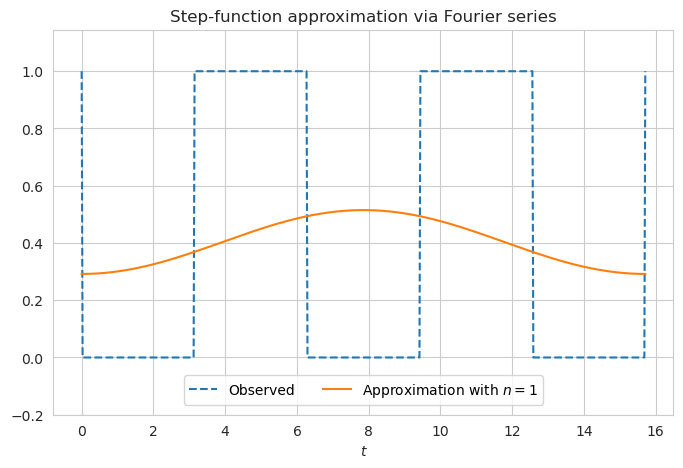

In [180]:
def step_function(x, period=2*np.pi, origin=0):
    length_from_origin = abs(x - origin)
    if length_from_origin%period < period/2 and x > 0:
        return 0
    elif length_from_origin%period > period/2 and x < 0:
        return 0
    else:
        return 1


P = 5*np.pi  # period to approximate
t = np.linspace(0, P, 600)  # range of t


observed_values = [step_function(element) for element in t]


def fourier_series(t,
                   obs_vals,
                   period=P, n=5):

    def get_c_coef(n):
        """Get Riemann sum instead of the integral in order to approximate."""
        ind_c_elements = np.array(obs_vals) * np.exp(-1j*2*np.pi*n*t/period)
        return ind_c_elements.sum()/ind_c_elements.size

    if isinstance(n, int):
        nth_series = np.array([get_c_coef(i)*np.exp(1j*2*np.pi*i*t/period) for i in range(1, n+1)])
    elif isinstance(n, list) or isinstance(n, np.ndarray):
        nth_series = np.array([get_c_coef(i)*np.exp(1j*2*np.pi*i*t/period) for i in n])
    fourier_series = nth_series.sum(axis=0)
        
    return fourier_series

fourier_series_init = fourier_series(t, observed_values, n=np.arange(-50,51)).real

with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize=(8, 5))

line_observed, = ax.plot(t, observed_values, linestyle='--', label='Observed')
line_approximated, = ax.plot(t, fourier_series_init, label='Approximation')
ax.set_xlabel('$t$')
ax.set_title('Step-function approximation via Fourier series')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.12),
          fancybox=True, ncols=2)
ax.set_ylim(bottom=-0.2)


def animate(i):
    fourier_series_current = fourier_series(t, observed_values, n=np.arange(-i,i)).real
    line_approximated.set_data(t, fourier_series_current)
    ax.get_legend().texts[1].set_text(f'Approximation with $n=${i}')
    return line_approximated,


ani = FuncAnimation(
    fig,
    animate,
    interval=200,
    blit=True,  # blitting can't be used with Figure artists
    frames=range(1, 53, 2),
    repeat_delay=100,
)

In [181]:
ani

In [182]:
ani.save('../../assets/images/optimization/step_function_approximation_fourier.gif');

# Rotating arrows in complex space

In [ ]:
from matplotlib.patches import FancyArrow

class Arrow:
    
    def __init__(self, n, cn, period):
        self.cn = cn
        self.n = n
        self.val = cn
        self.start = complex
        self.end = complex
        self.len = abs(self.val)
        self.period = period
    
    def update(self, t, new_start = 0):
        #self.t = self.t+self.dt
        #self.val = self.cn*np.exp(1j*self.n*2*np.pi*self.t/self.period)
        self.val = self.cn*np.exp(1j*self.n*2*np.pi*t/self.period)
        self.start = new_start
        self.end = self.start+self.val



In [183]:
complex

complex

In [185]:
abc

NameError: name 'abc' is not defined